# Classifying Face Images with SVM

After listening to an old episode of the Linear Digressions podcast, I became very interested in the implementation of Support Vector Machines for facial recognition and eigenfaces. In this notebook, I am going to go through a short SVM classification project to better understand this implementation. 

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Quick Explore the DataSet 

For this project, I am going to be using a build in sklearn dataset that contains the faces of famous people. I make my training easier, I am only going to use people that have at least 80 training samples in the dataset. 

In [2]:
## Exploring the Face Dataset 
from sklearn.datasets import fetch_lfw_people
face_data = fetch_lfw_people(min_faces_per_person = 80) # want at least 80 faces for training

In [5]:
X = face_data.data
Y = face_data.target

print('Input data sixe : ', X.shape)
print('Output data size : ', Y.shape)

print('Label Names : ', face_data.target_names)

Input data sixe :  (1140, 2914)
Output data size :  (1140,)
Label Names :  ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']


In [6]:
# Look for class imbalances
for i in range(len(face_data.target_names)):
    print(f'Class {i} has {(Y==i).sum()} samples.')

Class 0 has 236 samples.
Class 1 has 121 samples.
Class 2 has 530 samples.
Class 3 has 109 samples.
Class 4 has 144 samples.


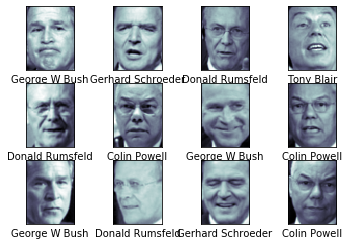

In [7]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3,4)
for i, axi in enumerate(ax.flat):
    axi.imshow(face_data.images[i], cmap = 'bone')
    axi.set(xticks=[], yticks = [], xlabel = face_data.target_names[face_data.target[i]])

## Building a basic SVM Classifier

In this section, I am going to go over the basics of building the SVM classifier. SVM is a simple and powerful traditional machine learning classifier that works particularly well in high dimensional spaces, or when the number of dimensions is greater than the number of samples. In binary classification, it works by separating the n-dimensional space into two spaces separated by a hyperplane. Another important part of this technique is the maximum-margin aspect of SVM. The margin is the closest space between positive and negative values. SVM works to maximize this margin to help with generality, putting in almost a buffer of sorts. 

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state = 42)


In this notebook, I am going to start by using the traditional SVM sklearn classifier SVC (Support Vector Classifier). Some important paramters of this classifier that we will not change from the default are: 

* Loss: Hinge Loss is used in traditional SVM. This can also be squared hinge, which I will not use. 
* Shrinking: Default true. This is a technique used to improve training time, where unneeded points are not included in the optimization problem. In turn, shrinking it, so training can be sped up. 



### Some of the Parameters for Grid Search

* C: Default of 1. SVM is not known for being able to handle outliers well. Without a tradeoff, the classifier will always find a perfect split between data points. While this might seem great, this does not do well for generalization. Instead, the hyperparameter C controls a tradeoff between maximizing margin and allowing tolerance. 
    * High C: penalty for misclassification is high. Data segregation is stricter and model is prone to overfitting. 
    * Low C: Influence of misclassification is low. Allows more misclassification and is less strict. Might have high bias. 
____________________
* Gamma: Since I am using a nonlinear SVM, the Gamma function helps adjust the kernel values (which I will talk about next). This gamma function basically works as a kernel coefficient that determines how strict the kernel function fits the observations. 
    * Small Gamma: implies high variance, possible underfitting
    * Large Gamma: low variance, possible overfitting 
_____________________
* Kernel: Kernels were created to solve non-linera classification problems by converting the original feature space to a higher dimensional feature space with a transformation function. Its known as the kernel trick because it doesn't actually explicitly map the original data point in higher space, instead it is implicitly done in low dimensional space. 
    * RBF: The most popular kernel function. It is the Gaussian kernel. If there is no prior knowledge of distribution, the RBF is the most popular kernel method. 
    * Polynomial: Maps it to a polynomial function. There is another parameter to add "D" the number of dimensions, so prior knowledge might be important. 
    * Sigmoid: This kernel uses the popular sigmoid function. This can be on par with the RBF kernel, but only under certain parameters. 

### Running the Code

In [11]:
## Balanced class weight emphasizes the underrepresented classes
clf = SVC(class_weight = 'balanced', random_state = 42)

In [12]:
parameters = {'C': [0.1,1,10],
             'gamma': [1e-07, 1e-08, 1e-06],
              'kernel': ['rbf', 'linear']}
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(clf,parameters, n_jobs = 1, cv = 5)

In [13]:
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', random_state=42),
             n_jobs=1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1e-07, 1e-08, 1e-06],
                         'kernel': ['rbf', 'linear']})

In [14]:
print('The best model:\n', grid_search.best_params_)

The best model:
 {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}


In [15]:
print('The best averaged performance:', grid_search.best_score_)

The best averaged performance: 0.8514619883040936


In [16]:
clf_best = grid_search.best_estimator_
pred = clf_best.predict(X_test)

In [17]:
print(f'The accuracy is: {clf_best.score(X_test, Y_test)*100:.1f}%')

The accuracy is: 87.7%


In [29]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred, target_names = face_data.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.91      0.95      0.93        64
  Donald Rumsfeld       0.77      0.84      0.81        32
    George W Bush       0.95      0.91      0.93       127
Gerhard Schroeder       0.81      0.86      0.83        29
       Tony Blair       0.93      0.85      0.89        33

         accuracy                           0.90       285
        macro avg       0.87      0.88      0.88       285
     weighted avg       0.90      0.90      0.90       285



## Introduction to PCA and Eigenfaces

One of the reasons I was most excited to work on this practice problem was the idea of the ghost eigenfaces dicussed in the podcast. Eigenfaces are basically lower dimension ghost faces created after PCA 

Code taken from online SVM documentation. 

In [46]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = face_data.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = face_data.data
n_features = X.shape[1]

In [50]:
## Implement PCA 
from time import time
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 150 eigenfaces from 855 faces
done in 0.172s


In [51]:
## Show Eigenfaces
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

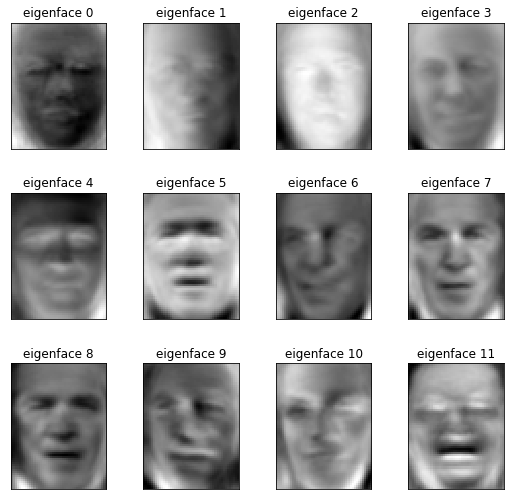

In [52]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Boost image Classification Performance with PCA

PCA works to compress the input features (or reduce the dimensions) to preserve only the most important internal relationships among features. We hope that we can this can help prevent overfitting. 

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten = True, random_state = 42)
svc = SVC(class_weight = 'balanced', kernel = 'rbf',random_state = 42)

from sklearn.pipeline import Pipeline
model = Pipeline([('pca', pca),('svc',svc)])

In [23]:
parameters_pipeline = {'svc__C' : [1,3,10],
                      'svc__gamma' : [0.001, 0.005]}

grid_search = GridSearchCV(model, parameters_pipeline)
grid_search.fit(X_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=100, random_state=42,
                                            whiten=True)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            random_state=42))]),
             param_grid={'svc__C': [1, 3, 10], 'svc__gamma': [0.001, 0.005]})

In [24]:
print('The best model:\n', grid_search.best_params_)

The best model:
 {'svc__C': 1, 'svc__gamma': 0.005}


In [25]:
print('The best averaged performance:', grid_search.best_score_)

The best averaged performance: 0.8654970760233918


In [26]:
model_best = grid_search.best_estimator_
pred = model_best.predict(X_test)

In [27]:
print(classification_report(Y_test,pred, target_names = face_data.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.91      0.95      0.93        64
  Donald Rumsfeld       0.77      0.84      0.81        32
    George W Bush       0.95      0.91      0.93       127
Gerhard Schroeder       0.81      0.86      0.83        29
       Tony Blair       0.93      0.85      0.89        33

         accuracy                           0.90       285
        macro avg       0.87      0.88      0.88       285
     weighted avg       0.90      0.90      0.90       285



### Side Note: Linear vs RBF 

In this notebook, I used the nonlinear RBF kernel because it is a common technique to attack this type of problem. However, in this side bar I am going to attempt to use the Linear technique to compare faces. Using linear vs RBF can be hard to decide but here are some justifications: